# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

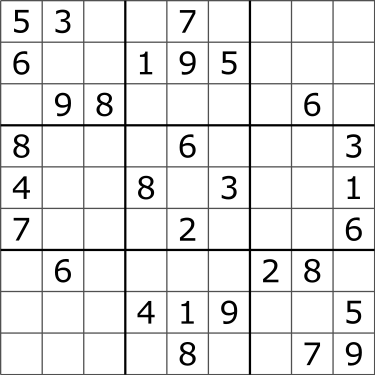

## Prepare environment

In [1]:
import sys
import os

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# TODO: how to get rid of src (this is the only way VS Code resolves it)
from src.sudoku_solver.data.dataset import prepare_dataset
from src.sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from src.sudoku_solver.model.model import prepare_model
from src.sudoku_solver.model.training import prepare_callbacks
from src.sudoku_solver.model.evaluation import plot_histories

import numpy as np
import tensorflow as tf
import keras

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

2025-04-29 11:50:19.984901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745920220.006068   70212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745920220.012725   70212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 11:50:20.032831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
DATA_SIZE_LIMIT = 20_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

USE_DISK_CACHE = False

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk
Serialized data folder ./sudoku_tfrecords/train_00 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_01 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_02 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_03 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_04 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_05 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_06 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_07 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_08 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_09 not found or empty.
Serialized data folder ./sudoku_tfrecords/val not found or empty.
Serialized data folder ./sudoku_tfrecords/test not found or empty.
Pre-processed sudoku data not found on disk. Downloading new version...
Path to dataset files: /home/martin/.cache/kaggle

I0000 00:00:1745920231.629500   70212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Decoded CSV shape: (2, 9000000)
Download complete. Starting preprocess...
Original difficulty distribution: [     0      0      0      0      0      0      0      0    103    188
    282    456    642   1044   1390   1922   2619   3584   4825   6558
   8405  11128  14376  18327  23417  29746  37918  47977  59119  73584
  90280 110194 133085 160784 193094 228562 269619 315259 364182 415920
 470816 523576 573332 614257 642208 650944 635339 591077 517507 424195
 314756 208498 118817  56760  21546   6304   1297    182]
Train difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01
 0.02 0.02 0.03 0.04 0.05 0.07 0.09 0.12 0.16 0.2  0.26 0.33 0.42 0.53
 0.66 0.82 1.   1.22 1.48 1.79 2.15 2.54 3.   3.5  4.05 4.62 5.23 5.82
 6.37 6.83 7.14 7.23 7.06 6.57 5.75 4.71 3.5  2.32 1.32 0.63 0.24 0.07
 0.01 0.  ]
Val difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01
 0.02 0.02 0.03 0.04 0.05 

2025-04-29 14:04:38.917099: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_00 855000


2025-04-29 14:08:05.126402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_01 855000
./sudoku_tfrecords/train_02 855000


2025-04-29 14:13:54.612920: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_03 855000
./sudoku_tfrecords/train_04 855000
./sudoku_tfrecords/train_05 855000
./sudoku_tfrecords/train_06 855000


2025-04-29 14:25:31.341673: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_07 855000
./sudoku_tfrecords/train_08 855000
./sudoku_tfrecords/train_09 855000
./sudoku_tfrecords/val 225000
./sudoku_tfrecords/test 225000
Dataset ready.


Measuring pipeline performance...: 100%|██████████| 1000/1000 [00:19<00:00, 52.06it/s]

Average batch fetch time is: 0.06422295808792114


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)).astype(int))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate dataset pipeline:



2025-04-29 14:33:17.308152: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[[0 1 0 6 2 9 0 8 5]
 [9 7 8 0 0 0 6 2 0]
 [6 0 0 0 8 7 0 0 0]
 [0 0 3 8 0 6 1 9 2]
 [2 5 0 4 9 1 3 7 8]
 [8 9 1 2 7 3 0 4 6]
 [4 3 0 7 6 5 8 1 9]
 [5 8 9 3 1 0 4 6 0]
 [0 6 7 0 4 8 2 5 0]]
[[3 1 4 6 2 9 7 8 5]
 [9 7 8 5 3 4 6 2 1]
 [6 2 5 1 8 7 9 3 4]
 [7 4 3 8 5 6 1 9 2]
 [2 5 6 4 9 1 3 7 8]
 [8 9 1 2 7 3 5 4 6]
 [4 3 2 7 6 5 8 1 9]
 [5 8 9 3 1 2 4 6 7]
 [1 6 7 9 4 8 2 5 3]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

2025-04-29 14:33:49.403252: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000

## Train model

### Prepare model

In [6]:
model = prepare_model(use_residual=USE_RESIDUAL, learning_rate=LEARNING_RATE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
histories = []
for train_dataset in train_datasets:
    training_callbacks = prepare_callbacks()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    histories.append(history)

Epoch 1/3


I0000 00:00:1745930043.438079   70319 service.cc:148] XLA service 0x7f16b000c680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745930043.438575   70319 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-29 14:34:03.678816: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745930044.686941   70319 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-29 14:34:06.206789: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[256,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_m

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6757 - loss: 1.0272

2025-04-29 14:37:55.746825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 14:38:27.402157: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 276s 125ms/step - accuracy: 0.6757 - loss: 1.0269 - val_accuracy: 0.7937 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9407 - loss: 0.2917

2025-04-29 14:42:12.878242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 14:42:42.569289: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 255s 124ms/step - accuracy: 0.9407 - loss: 0.2917 - val_accuracy: 0.8047 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9519 - loss: 0.2535

2025-04-29 14:46:29.360441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 14:46:59.161690: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 125ms/step - accuracy: 0.9519 - loss: 0.2535 - val_accuracy: 0.8149 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9068 - loss: 0.3799

2025-04-29 14:50:46.434704: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 14:51:16.181354: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 258s 126ms/step - accuracy: 0.9068 - loss: 0.3799 - val_accuracy: 0.8291 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9182 - loss: 0.3401

2025-04-29 14:55:06.313248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 14:55:36.062750: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 259s 125ms/step - accuracy: 0.9182 - loss: 0.3401 - val_accuracy: 0.8375 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9266 - loss: 0.3128

2025-04-29 14:59:23.120540: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.9266 - loss: 0.3128 - val_accuracy: 0.8463 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9030 - loss: 0.3787

2025-04-29 15:03:40.400422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 128ms/step - accuracy: 0.9030 - loss: 0.3787 - val_accuracy: 0.8534 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9114 - loss: 0.3522

2025-04-29 15:08:04.296744: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 260s 126ms/step - accuracy: 0.9114 - loss: 0.3522 - val_accuracy: 0.8620 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9181 - loss: 0.3323

2025-04-29 15:12:21.600098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 125ms/step - accuracy: 0.9181 - loss: 0.3323 - val_accuracy: 0.8666 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9001 - loss: 0.3820

2025-04-29 15:16:39.817443: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 128ms/step - accuracy: 0.9001 - loss: 0.3820 - val_accuracy: 0.8722 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9061 - loss: 0.3635

2025-04-29 15:21:00.675865: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.9061 - loss: 0.3635 - val_accuracy: 0.8775 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9100 - loss: 0.3514

2025-04-29 15:25:18.012313: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.9100 - loss: 0.3514 - val_accuracy: 0.8801 - val_loss: 0.4213 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8903 - loss: 0.4044

2025-04-29 15:29:35.444431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 128ms/step - accuracy: 0.8903 - loss: 0.4044 - val_accuracy: 0.8805 - val_loss: 0.4165 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8939 - loss: 0.3926

2025-04-29 15:33:56.513008: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 256s 125ms/step - accuracy: 0.8939 - loss: 0.3926 - val_accuracy: 0.8814 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8962 - loss: 0.3855

2025-04-29 15:38:14.484745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 259s 127ms/step - accuracy: 0.8962 - loss: 0.3855 - val_accuracy: 0.8841 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8813 - loss: 0.4248

2025-04-29 15:42:33.826330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 128ms/step - accuracy: 0.8813 - loss: 0.4248 - val_accuracy: 0.8878 - val_loss: 0.3996 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8840 - loss: 0.4160

2025-04-29 15:46:55.020013: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 258s 126ms/step - accuracy: 0.8840 - loss: 0.4160 - val_accuracy: 0.8883 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8855 - loss: 0.4113

2025-04-29 15:51:13.737962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.8855 - loss: 0.4113 - val_accuracy: 0.8871 - val_loss: 0.3995 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8622 - loss: 0.4723

2025-04-29 15:55:32.387349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 266s 129ms/step - accuracy: 0.8622 - loss: 0.4723 - val_accuracy: 0.8893 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 2/3


2025-04-29 15:56:22.531796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:301: Filling up shuffle buffer (this may take a while): 14061 of 100000
2025-04-29 15:56:27.593651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8644 - loss: 0.4652

2025-04-29 16:00:09.034428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 269s 125ms/step - accuracy: 0.8644 - loss: 0.4652 - val_accuracy: 0.8897 - val_loss: 0.3904 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8659 - loss: 0.4608

2025-04-29 16:04:25.078497: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 125ms/step - accuracy: 0.8659 - loss: 0.4608 - val_accuracy: 0.8915 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8474 - loss: 0.5081

2025-04-29 16:08:41.792365: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.8474 - loss: 0.5081 - val_accuracy: 0.8899 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8491 - loss: 0.5022

2025-04-29 16:12:59.318732: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 125ms/step - accuracy: 0.8491 - loss: 0.5022 - val_accuracy: 0.8935 - val_loss: 0.3787 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8505 - loss: 0.4985

2025-04-29 16:17:16.465077: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.8505 - loss: 0.4985 - val_accuracy: 0.8955 - val_loss: 0.3747 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8280 - loss: 0.5549

2025-04-29 16:21:33.828866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 258s 126ms/step - accuracy: 0.8280 - loss: 0.5549 - val_accuracy: 0.8935 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8295 - loss: 0.5501

2025-04-29 16:25:51.578498: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 258s 126ms/step - accuracy: 0.8295 - loss: 0.5501 - val_accuracy: 0.8941 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8304 - loss: 0.5473

2025-04-29 16:30:09.994896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 258s 126ms/step - accuracy: 0.8303 - loss: 0.5473 - val_accuracy: 0.8911 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7991 - loss: 0.6257

2025-04-29 16:34:26.878958: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 257s 126ms/step - accuracy: 0.7991 - loss: 0.6257 - val_accuracy: 0.8962 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8005 - loss: 0.6207

2025-04-29 16:38:45.315480: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 261s 127ms/step - accuracy: 0.8005 - loss: 0.6207 - val_accuracy: 0.8967 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8013 - loss: 0.6182

2025-04-29 16:43:09.665118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 261s 128ms/step - accuracy: 0.8013 - loss: 0.6182 - val_accuracy: 0.8966 - val_loss: 0.3721 - learning_rate: 0.0010


### Save model

In [8]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

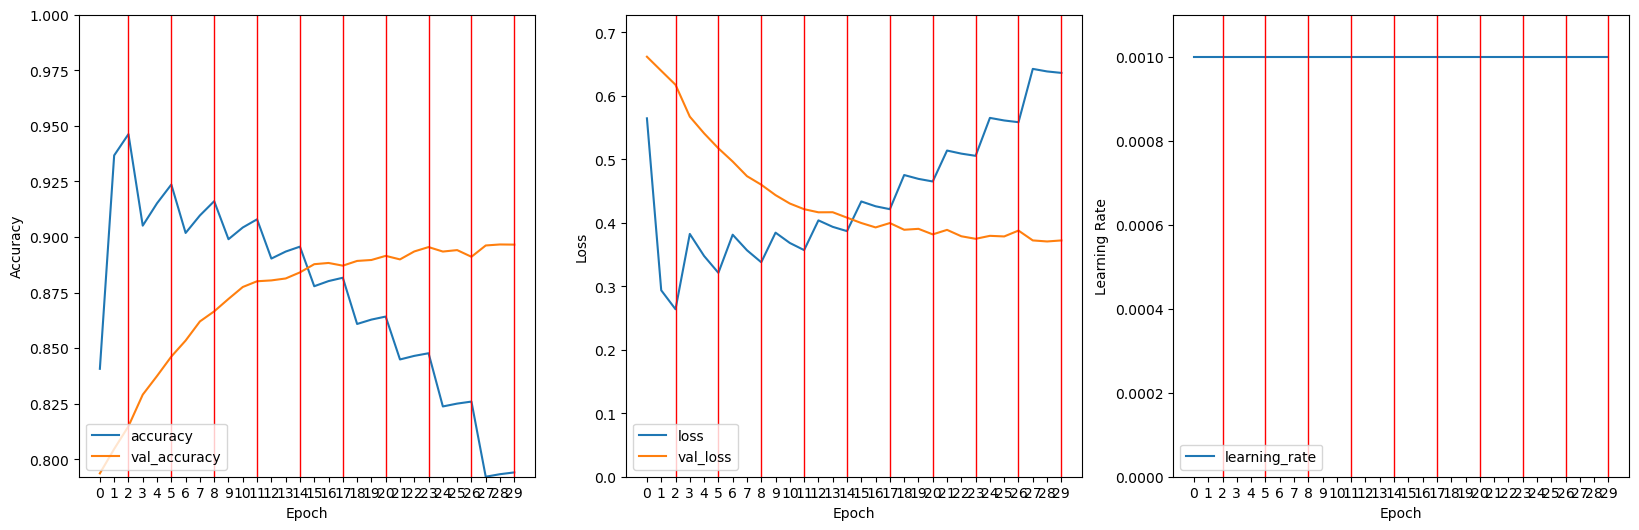

In [9]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [10]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [11]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [12]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [13]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [14]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

2025-04-29 16:43:47.372248: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 16:43:48.028832: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[9,16,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,5,5]{3,2,1,0}, f32[16,128,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[8 9 3 2 5 9 7 1 4]
 [4 2 5 1 6 7 8 1 3]
 [7 7 1 4 3 8 2 6 5]
 [6 1 2 8 4 5 3 9 7]
 [9 5 4 6 7 3 1 5 2]
 [3 5 7 9 1 2 5 4 6]
 [5 4 8 7 9 1 6 2 2]
 [6 3 6 5 2 4 6 8 9]
 [2 3 9 5 8 6 4 7 1]]


In [15]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745937830.293829   70319 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8519 - loss: 0.5901


In [16]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[4 2 2 5 1 9 6 3 7]
 [1 5 6 3 4 7 8 2 9]
 [3 7 9 8 2 6 5 4 1]
 [8 3 5 9 6 1 2 7 4]
 [6 7 7 4 8 3 2 1 5]
 [9 1 4 7 5 2 3 6 8]
 [2 6 2 1 7 5 4 9 3]
 [5 9 1 2 4 4 7 8 6]
 [7 4 3 6 9 8 1 5 2]]


In [17]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9383 - loss: 0.3702


0.9382716417312622

### Evaluate on different difficulties

In [18]:
for index, train_dataset in enumerate(train_datasets):
    loss, accuracy = model.evaluate(train_dataset, verbose=0)
    print(f"Difficulty {index + 1}: loss={loss}, accuracy={accuracy}")
    
    for X_batch, _ in train_dataset.take(1):
        avg_non_zero_count = tf.reduce_mean(tf.math.count_nonzero((X_batch + 0.5) * 9, axis=(1, 2)))
        print(f"Average non-zero numbers in puzzle in one batch: {int(avg_non_zero_count)}\n")


2025-04-29 16:45:04.336022: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 1: loss=0.13239967823028564, accuracy=0.9924752116203308


2025-04-29 16:45:11.137082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:45:11.204902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average non-zero numbers in puzzle in one batch: 59



2025-04-29 16:46:23.839007: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 2: loss=0.18942467868328094, accuracy=0.9702956676483154
Average non-zero numbers in puzzle in one batch: 47



2025-04-29 16:46:31.246642: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:47:44.421290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 3: loss=0.24059349298477173, accuracy=0.9497027397155762
Average non-zero numbers in puzzle in one batch: 43



2025-04-29 16:47:50.985622: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:49:04.587036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 4: loss=0.2873536944389343, accuracy=0.9307188391685486
Average non-zero numbers in puzzle in one batch: 41



2025-04-29 16:49:13.603566: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:50:30.289184: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 5: loss=0.3323933184146881, accuracy=0.9123557209968567
Average non-zero numbers in puzzle in one batch: 39



2025-04-29 16:50:37.926185: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:51:51.056353: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 6: loss=0.3760431706905365, accuracy=0.8945794701576233
Average non-zero numbers in puzzle in one batch: 38



2025-04-29 16:51:57.150293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:53:08.115290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 7: loss=0.4236644208431244, accuracy=0.8751427531242371
Average non-zero numbers in puzzle in one batch: 36



2025-04-29 16:53:15.275976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:54:29.992680: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 8: loss=0.4697689414024353, accuracy=0.8563204407691956
Average non-zero numbers in puzzle in one batch: 35



2025-04-29 16:54:37.094150: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:55:50.666302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 9: loss=0.5268533229827881, accuracy=0.8330361247062683
Average non-zero numbers in puzzle in one batch: 34



2025-04-29 16:55:58.266142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-29 16:57:14.062222: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Difficulty 10: loss=0.5977627635002136, accuracy=0.8042277693748474
Average non-zero numbers in puzzle in one batch: 32



2025-04-29 16:57:22.214918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Evaluate test set performance

In [19]:
loss, accuracy = model.evaluate(test_dataset)

878/878 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.8967 - loss: 0.3703


In [20]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.8966311812400818 and loss: 0.37045082449913025


The End